In [1]:
# import Pkg
# Pkg.add("CSV")
# Pkg.add("Dates")
# Pkg.add("DataFrames")
# Pkg.add("DataFramesMeta")
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Distances")
# Pkg.add("Random")
# Pkg.add("Distributions")
# Pkg.add("Statistics")
# Pkg.add("Graphs")
# Pkg.add("GraphPlot")
# Pkg.add("GMT")
# Pkg.add("MultiObjectiveAlgorithms")
# Pkg.add("Compose")
# Pkg.add("Cairo")
# Pkg.add("Colors")
# Pkg.add("ColorSchemes")
# Pkg.add("Fontconfig")
# Pkg.add("Leaflet")
# Pkg.add("GeoInterface")
# Pkg.add("GeoJSON")

In [2]:
using Plots
using Compose, Cairo, Fontconfig
using IJulia

In [3]:
include("./src/utils.jl")
include("./src/data.jl")
include("./src/opt.jl")
include("./src/out.jl")
include("./src/lagrange.jl")
include("./src/metrics.jl");

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-23


WebIO._IJuliaInit()

In [4]:
trips, shapes = loadGTFS("..\\data\\Nanaimo-GTFS");
# trips, shapes = loadGTFS("..\\data\\Cranbrook-GTFS");
historical_data = loadHistoricalData("..\\data");
first(historical_data, 5)

5×15 DataFrame
 Row │ route  trip_id   date        planned_start_time  planned_duration_secon ⋯
     │ Int64  Int64     Date        Time                Int64                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  73449258  2023-10-13  10:30:00                                17 ⋯
   2 │     1  73420181  2023-09-18  10:33:00                                15
   3 │     1  73448776  2023-10-19  18:05:00                                17
   4 │     1  73448308  2023-11-14  18:08:00                                15
   5 │     1  73448889  2023-10-26  16:20:00                                17 ⋯
                                                              11 columns omitted

## Individual Testing

In [5]:
# subset = subsetGTFS(trips; routes = [5, 6, 7, 8, 78], start_time = 0, stop_time = 12)
# trips_subset = subsetGTFS(trips; routes = [6, 15, 20, 30, 40])
# trips_subset = subsetGTFS(trips; start_time = 0, stop_time = 24)
trips_subset = subsetGTFS(trips; routes = [1, 30, 40, 5, 50, 6, 7, 8], stop_time = 24)
# trips_subset = trips
# subset = subsetGTFS(trips; n = 30, routes = [6, 15, 20, 30, 40], start_time = 8, stop_time = 12, randomSeed = 1)
# size(trips_subset, 1)
L = getHistoricalDelays(trips_subset, historical_data, 100)
r = getHistoricalRidership(trips_subset, historical_data)
instance = VSPInstance(trips_subset, r = r)
mcf_model = MCFModel(instance)
mcf_solution = solve!(mcf_model);
del_model = VSPModel(instance; L = L, split = 0.2, warmStart = mcf_solution, randomSeed = 1, timeLimit = 5 * 3600)
del_solution = solve!(del_model; silent = false);
rta_solution, rta_buffer = runTimeAnalysis(mcf_solution, del_model.L_train);

numTrips = 400
numVehicles = 31.0
isInt = true
termination_status(mod.model) = MathOptInterface.OPTIMAL
objective_value(mod.model) = 29079.526701170133
solve_time(mod.model) = 2996.2480001449585


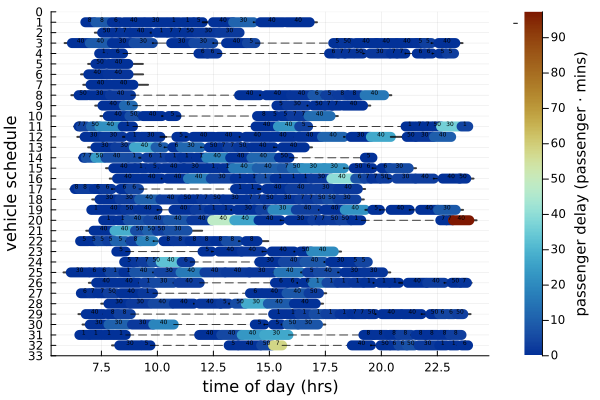

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [6]:
rta_plot_time = plotVSP_time(rta_solution; delays = del_model.L_test .- rta_buffer, ridership = instance.r)

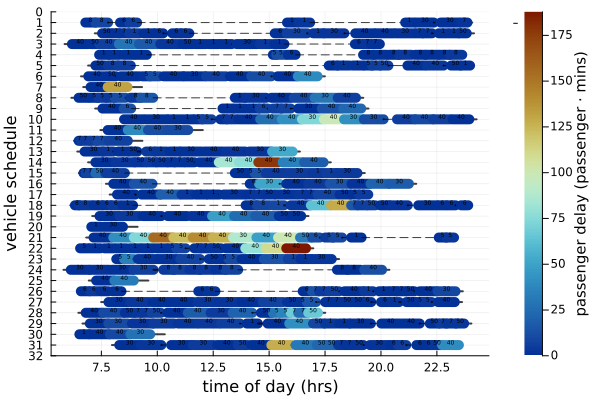

In [7]:
mcf_plot_time = plotVSP_time(mcf_solution; delays = del_model.L_test, ridership = instance.r)
# savefig(mcf_plot_time, ".\\imgs\\VSP-time-$(mcf_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1.png")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


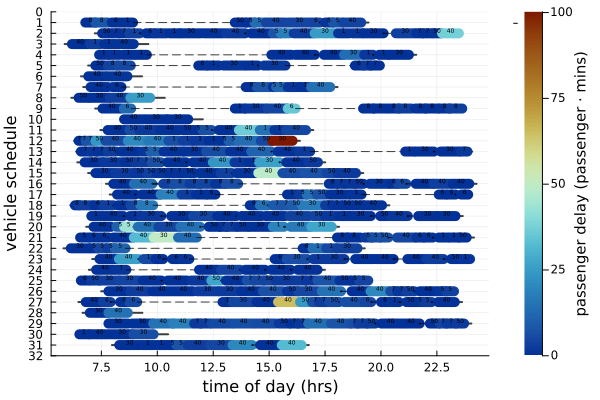

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [8]:
del_plot_time = plotVSP_time(del_solution; delays = del_model.L_test, ridership = instance.r)
# savefig(del_plot_time, ".\\imgs\\VSP-PD-time-$(del_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1.png")

In [9]:
mcf_stats = getSolutionStats(mcf_solution, shapes, del_model.L_test, ridership = instance.r);
rta_stats = getSolutionStats(rta_solution, shapes, del_model.L_test .- rta_buffer, ridership = instance.r);
del_stats = getSolutionStats(del_solution, shapes, del_model.L_test, ridership = instance.r);

In [10]:
@show mcf_stats.cost
@show rta_stats.cost
@show del_stats.cost;

mcf_stats.cost = 68971.8568255991
rta_stats.cost = 70822.57784224291
del_stats.cost = 67851.40505417236


In [10]:
# del_stats.metrics[:, Not("geometry")]
describe(del_stats.metrics[:, Not("geometry")])
# CSV.write(".\\data\\metrics\\VSP-PD-$(mcf_solution.mod.inst.n-1)-$(del_solution.mod.n_train)-1-adjacent.csv", del_stats[:, Not("geometry")])

7×7 DataFrame
 Row │ variable                        mean       min        median       max  ⋯
     │ Symbol                          Float64    Real       Float64      Real ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ duration                         2.61167    0.683333   2.825        3.4 ⋯
   2 │ num_trips                        3.0        1          3.0          5
   3 │ utilization                      0.776888   0.644172   0.776583     1.0
   4 │ propagated_passenger_delay       0.103535   0.0        0.0326542    0.5
   5 │ propagated_passenger_delay_err   0.192694   0.0        0.0565588    1.1 ⋯
   6 │ trip_distance                   52.8008    18.649     56.8865      75.4
   7 │ deadhead_distance                0.028717   0.0        0.00326455   0.2
                                                               3 columns omitted

## Leaflet

In [29]:
m = plotVSP_map(del_stats.metrics; schedule = nothing)

Leaflet.Map{Vector{Leaflet.Layer}, Leaflet.Config{Leaflet.Provider}, WebIO.Scope}(Leaflet.Layer[Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-124.05336, 49.23715], [-124.05365, 49.23735], [-124.05339, 49.23815], [-124.05296, 49.23843], [-124.05347, 49.23874], [-124.05402, 49.23891], [-124.05475, 49.239], [-124.05422, 49.24032], [-124.05394, 49.24103], [-124.05388, 49.24196]  …  [-123.93352, 49.16595], [-123.93308, 49.16609], [-123.93274, 49.16609], [-123.93219, 49.16586], [-123.93175, 49.16548], [-123.93149, 49.16543], [-123.93133, 49.16528], [-123.93125, 49.16501], [-123.93136, 49.16482], [-123.93233, 49.164049999999996]], nothing, nothing), Dict{Symbol, Any}(:color => "#822504", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93232727050781, 49.164048876953125], [-123.93232727050781, 49.164048876953125]], nothing, nothing), Dict{Symbol, Any}(:color => "gray", :border_width => 2, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93233, 49.164049999999996], [-123.93291, 49.16334], [-123.93319, 49.16341], [-123.93478, 49.16319], [-123.93517, 49.16351], [-123.93592, 49.16378], [-123.93638, 49.16385], [-123.93704, 49.16429], [-123.93825, 49.16483], [-123.94002, 49.16608]  …  [-124.05347, 49.23874], [-124.05296, 49.23843], [-124.05339, 49.23815], [-124.05366, 49.23746], [-124.05353, 49.23721], [-124.05327, 49.237049999999996], [-124.05366, 49.2368], [-124.05296, 49.23635], [-124.05253, 49.23652], [-124.05299, 49.23694]], nothing, nothing), Dict{Symbol, Any}(:color => "#822504", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-124.05299377441406, 49.23694011230469], [-124.05335998535156, 49.237149920654296]], nothing, nothing), Dict{Symbol, Any}(:color => "gray", :border_width => 2, :opacity => 0.5, :color_map => "nothing", :fill_opacity => 0.5, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-124.05336, 49.23715], [-124.05365, 49.23735], [-124.05339, 49.23815], [-124.05223, 49.238839999999996], [-124.05137, 49.23948], [-124.0496, 49.23888], [-124.04922, 49.238749999999996], [-124.0473, 49.23763], [-124.04617, 49.23669], [-124.04498, 49.2352]  …  [-123.93638, 49.16385], [-123.93598, 49.16372], [-123.93574, 49.1636], [-123.93546, 49.16362], [-123.93517, 49.16351], [-123.93478, 49.16319], [-123.93319, 49.16341], [-123.93291, 49.16334], [-123.93208, 49.1641], [-123.93158, 49.16446]], nothing, nothing), Dict{Symbol, Any}(:color => "#822504", :border_width => 2, :opacity => 1, :color_map => "nothing", :fill_opacity => 1, :marker_size => 3.0)), Leaflet.Layer{GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}}(GeoInterface.Wrappers.LineString{false, false, Vector{Vector{Float64}}, Nothing, Nothing}([[-123.93233, 49.164049999999996], [-123.93291, 49.16334], [-123.93319, 49.16341], [-123.93478, 49.16319], [-123.93517, 49.16351], [-123.93592, 49.16378], [-123.93638, 49.16385], [-123.93704, 49.16429], [-123.93825, 49.16483], [-123.94002, 49.16608]  …  [

## Overfitting to Mean

In [ ]:
mcf_dict = Dict(
    "similarity" => [],
    "utilization" => [],
    "cost" => [],
    "cost_err" => [],
    "vehicle_cost" => [],
    "link_cost" => [],
    "passenger_cost" => [],
    "passenger_cost_err" => [],
    "service_cost" => [],
    "service_cost_err" => [],
    "delay" => [],
    "delay_std" => [],
    "deadhead" => [],
)
mean_dict = Dict(
    "similarity" => [],
    "utilization" => [],
    "cost" => [],
    "cost_err" => [],
    "vehicle_cost" => [],
    "link_cost" => [],
    "passenger_cost" => [],
    "passenger_cost_err" => [],
    "service_cost" => [],
    "service_cost_err" => [],
    "delay" => [],
    "delay_std" => [],
    "deadhead" => [],
)
stoch_dict = Dict(
    "similarity" => [],
    "utilization" => [],
    "cost" => [],
    "cost_err" => [],
    "vehicle_cost" => [],
    "link_cost" => [],
    "passenger_cost" => [],
    "passenger_cost_err" => [],
    "service_cost" => [],
    "service_cost_err" => [],
    "delay" => [],
    "delay_std" => [],
    "deadhead" => [],
)
n = 100
ratio = 0.2
seed = 1
multis = 0.4:0.2:2.0

let
    prev_sol = nothing
    # subset = subsetGTFS(trips; routes = [6, 15, 20, 30, 40])
    subset = subsetGTFS(trips; routes = [1, 30, 40, 5, 50, 6, 7, 8], stop_time = 24)
    # subset = subsetGTFS(trips; start_time = 0, stop_time = 24)
    L = getHistoricalDelays(subset, historical_data, n; randomSeed = seed)
    n_train = sample(1:n, Int(n*ratio), replace = false)
    L_train_base = L[:, n_train]
    L_test_base = L[:, Not(n_train)]
    r = getHistoricalRidership(subset, historical_data)
    for multi in multis
        # IJulia.clear_output(true)
        println("multi: $multi")
        # subset = subsetGTFS(trips; routes = [6, 15, 20, 30, 40], start_time = 0, stop_time = 12)
        # subset = subsetGTFS(trips; routes = [5, 6, 7, 8, 78], start_time = 0, stop_time = 12)
        L_train = L_train_base .* multi
        L_test = L_test_base .* multi
        # l = getDelays(subset; stdMulti = multi)
        # L = hcat(rand.(l, n_train)...)'
        # L = vcat(zeros(Float64, 1, n_train), L)
        # L_test = hcat(rand.(l, n_test)...)'
        # L_test = vcat(zeros(Float64, 1, n_test), L_test)
        # μ_L = mean(L, dims=2)
        # μ_L = reshape(μ_L, length(μ_L), 1)
        # r = getRidership(subset)
        instance = VSPInstance(subset; r = r)
        # instance = VSPInstance(subset; l = l, r = r)
        mcf_model = MCFModel(instance)
        mcf_solution = solve!(mcf_model)
        mean_model = VSPModel(instance; L = mean(L_train, dims=2), warmStart = mcf_solution, timeLimit = 120)
        mean_solution = solve!(mean_model)
        if isnothing(prev_sol)
            prev_sol = mean_solution
        end
        stoch_model = VSPModel(instance; L = L_train, warmStart = prev_sol, randomSeed = seed, timeLimit = 2 * 3600)
        stoch_solution = solve!(stoch_model)
        prev_sol = stoch_solution
        stoch_stats = getSolutionStats(stoch_solution, shapes, L_test, ridership = r)
        mcf_stats = getSolutionStats(mcf_solution, shapes, L_test, ridership = r)
        mean_stats = getSolutionStats(mean_solution, shapes, L_test, ridership = r)

        push!(mcf_dict["similarity"], compareSchedules(mcf_solution, mcf_solution))
        push!(mcf_dict["utilization"], mcf_stats.utilization)
        push!(mcf_dict["cost"], mcf_stats.cost)
        push!(mcf_dict["cost_err"], mcf_stats.cost_err)
        push!(mcf_dict["vehicle_cost"], mcf_stats.vehicle_cost)
        push!(mcf_dict["link_cost"], mcf_stats.link_cost)
        push!(mcf_dict["passenger_cost"], mcf_stats.passenger_cost)
        push!(mcf_dict["passenger_cost_err"], mcf_stats.passenger_cost_err)
        push!(mcf_dict["service_cost"], mcf_stats.service_cost)
        push!(mcf_dict["service_cost_err"], mcf_stats.service_cost_err)
        push!(mcf_dict["delay"], mcf_stats.μ)
        push!(mcf_dict["delay_std"], mcf_stats.σ)
        push!(mcf_dict["deadhead"], mcf_stats.deadhead)
        push!(mean_dict["similarity"], compareSchedules(mean_solution, mcf_solution))
        push!(mean_dict["utilization"], mean_stats.utilization)
        push!(mean_dict["cost"], mean_stats.cost)
        push!(mean_dict["cost_err"], mean_stats.cost_err)
        push!(mean_dict["vehicle_cost"], mean_stats.vehicle_cost)
        push!(mean_dict["link_cost"], mean_stats.link_cost)
        push!(mean_dict["passenger_cost"], mean_stats.passenger_cost)
        push!(mean_dict["passenger_cost_err"], mean_stats.passenger_cost_err)
        push!(mean_dict["service_cost"], mean_stats.service_cost)
        push!(mean_dict["service_cost_err"], mean_stats.service_cost_err)
        push!(mean_dict["delay"], mean_stats.μ)
        push!(mean_dict["delay_std"], mean_stats.σ)
        push!(mean_dict["deadhead"], mean_stats.deadhead)
        push!(stoch_dict["similarity"], compareSchedules(stoch_solution, mcf_solution))
        push!(stoch_dict["utilization"], stoch_stats.utilization)
        push!(stoch_dict["cost"], stoch_stats.cost)
        push!(stoch_dict["cost_err"], stoch_stats.cost_err)
        push!(stoch_dict["vehicle_cost"], stoch_stats.vehicle_cost)
        push!(stoch_dict["link_cost"], stoch_stats.link_cost)
        push!(stoch_dict["passenger_cost"], stoch_stats.passenger_cost)
        push!(stoch_dict["passenger_cost_err"], stoch_stats.passenger_cost_err)
        push!(stoch_dict["service_cost"], stoch_stats.service_cost)
        push!(stoch_dict["service_cost_err"], stoch_stats.service_cost_err)
        push!(stoch_dict["delay"], stoch_stats.μ)
        push!(stoch_dict["delay_std"], stoch_stats.σ)
        push!(stoch_dict["deadhead"], stoch_stats.deadhead)
    end
    println("complete")
end

multi: 0.4
multi: 0.6
multi: 0.8
multi: 1.0
multi: 1.2
multi: 1.4


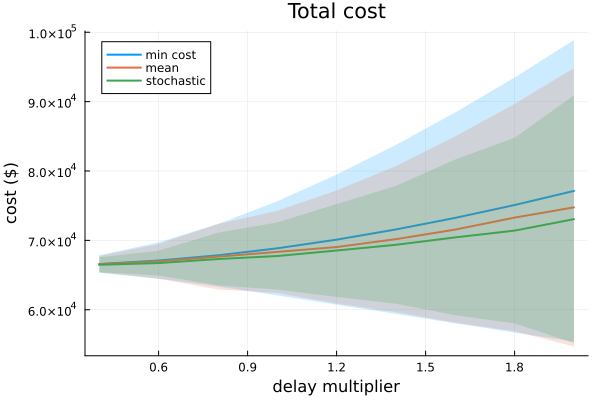

In [19]:
cost = plot(
    multis,
    [mcf_dict["cost"] mean_dict["cost"] stoch_dict["cost"]],
    ribbon=[mcf_dict["cost_err"] mean_dict["cost_err"] stoch_dict["cost_err"]],
    fillalpha=0.2,
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="cost (\$)",
    title="Total cost",
    legend=:topleft
)
vehicle_cost = plot(
    multis,
    [mcf_dict["vehicle_cost"] mean_dict["vehicle_cost"] stoch_dict["vehicle_cost"]],
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="cost (\$)",
    title="Vehicle cost",
    legend=nothing
)
link_cost = plot(
    multis,
    [mcf_dict["link_cost"] mean_dict["link_cost"] stoch_dict["link_cost"]],
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="cost (\$)",
    title="Link cost",
    legend=nothing
)
passenger_cost = plot(
    multis,
    [mcf_dict["passenger_cost"] mean_dict["passenger_cost"] stoch_dict["passenger_cost"]],
    ribbon=[mcf_dict["passenger_cost_err"] mean_dict["passenger_cost_err"] stoch_dict["passenger_cost_err"]],
    fillalpha=0.2,
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="cost (\$)",
    title="Passenger cost",
    legend=nothing
)
service_cost = plot(
    multis,
    [mcf_dict["service_cost"] mean_dict["service_cost"] stoch_dict["service_cost"]],
    ribbon=[mcf_dict["service_cost_err"] mean_dict["service_cost_err"] stoch_dict["service_cost_err"]],
    fillalpha=0.2,
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="cost (\$)",
    title="Service cost",
    legend=nothing
)
delay = plot(
    multis,
    [mcf_dict["delay"] mean_dict["delay"] stoch_dict["delay"]],
    ribbon=[mcf_dict["delay_std"] mean_dict["delay_std"] stoch_dict["delay_std"]],
    fillalpha=0.2,
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="person ⋅ mins",
    title="Passenger delay per trip",
    legend=nothing
)
deadhead = plot(
    multis,
    [mcf_dict["deadhead"] mean_dict["deadhead"] stoch_dict["deadhead"]],
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="minutes",
    title="Deadhead",
    legend=nothing
)
similarity = plot(
    multis,
    [mcf_dict["similarity"] mean_dict["similarity"] stoch_dict["similarity"]],
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="percent (%)",
    title="Similarity to min cost",
    legend=nothing
)
utilization = plot(
    multis,
    [mcf_dict["utilization"] mean_dict["utilization"] stoch_dict["utilization"]],
    label=["min cost" "mean" "stochastic"],
    lw=2,
    xlabel="delay multiplier",
    ylabel="percent (%)",
    title="Utilization",
    legend=nothing
)
# mean_comparison_plot = plot(cost, delay, vehicle_cost, link_cost, passenger_cost, service_cost, deadhead, utilization, similarity,  layout=(3, 3), link=:xy, size=(900, 600))
cost

## Single Instance RTA

In [52]:
mcf_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "total_cost" => [],
    "total_cost_std" => [],
    "vehicle_cost" => [],
    "vehicle_cost_std" => [],
    "link_cost" => [],
    "link_cost_std" => [],
    "passenger_cost" => [],
    "passenger_cost_std" => [],
    "service_cost" => [],
    "service_cost_std" => [],
    "deadhead" => [],
    "deadhead_std" => [],
)
rta_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "total_cost" => [],
    "total_cost_std" => [],
    "vehicle_cost" => [],
    "vehicle_cost_std" => [],
    "link_cost" => [],
    "link_cost_std" => [],
    "passenger_cost" => [],
    "passenger_cost_std" => [],
    "service_cost" => [],
    "service_cost_std" => [],
    "deadhead" => [],
    "deadhead_std" => [],
)
stoch_dict = Dict(
    "similarity" => [],
    "similarity_std" => [],
    "utilization" => [],
    "utilization_std" => [],
    "total_cost" => [],
    "total_cost_std" => [],
    "vehicle_cost" => [],
    "vehicle_cost_std" => [],
    "link_cost" => [],
    "link_cost_std" => [],
    "passenger_cost" => [],
    "passenger_cost_std" => [],
    "service_cost" => [],
    "service_cost_std" => [],
    "deadhead" => [],
    "deadhead_std" => [],
)
numSeeds = 10
n_train = 10
n_test = 100
# x = 25:25:100
multis = 0.0:0.05:0.5

for multi in multis
    mcf = Dict(
        "similarity" => [],
        "utilization" => [],
        "total_cost" => [],
        "vehicle_cost" => [],
        "link_cost" => [],
        "passenger_cost" => [],
        "service_cost" => [],
        "deadhead" => [],
    )
    rta = Dict(
        "similarity" => [],
        "utilization" => [],
        "total_cost" => [],
        "vehicle_cost" => [],
        "link_cost" => [],
        "passenger_cost" => [],
        "service_cost" => [],
        "deadhead" => [],
    )
    stoch = Dict(
        "similarity" => [],
        "utilization" => [],
        "total_cost" => [],
        "vehicle_cost" => [],
        "link_cost" => [],
        "passenger_cost" => [],
        "service_cost" => [],
        "deadhead" => [],
    )
    # subset = subsetGTFS(trips; routes = [6, 15, 20, 30, 40], start_time = 0, stop_time = 10)
    subset = subsetGTFS(trips; routes = [5, 6, 7, 8, 78], start_time = 0, stop_time = 12)
    for seed in 1:numSeeds
        IJulia.clear_output(true)
        println("multi: $multi")
        println("progress: $seed / $numSeeds")
        # subset = subsetGTFS(trips; n = n, randomSeed = seed)
        l = getDelays(subset; randomSeed = seed, meanMulti = multi)
        L = hcat(rand.(l, n_train)...)'
        L = vcat(zeros(Float64, 1, n_train), L)
        L_test = hcat(rand.(l, n_test)...)'
        L_test = vcat(zeros(Float64, 1, n_test), L_test)
        μ_L = mean(L, dims=2)
        μ_L = reshape(μ_L, length(μ_L), 1)
        r = getRidership(subset; randomSeed = seed)
        instance = VSPInstance(subset; l = l, r = r)
        mcf_model = MCFModel(instance)
        mcf_solution = solve!(mcf_model)
        mcf_stats = getSolutionStats(mcf_solution, shapes, L_test, ridership = r)
        stoch_model = VSPModel(instance; L = L, warmStart = mcf_solution, timeLimit = 120)
        stoch_solution = solve!(stoch_model)
        stoch_stats = getSolutionStats(stoch_solution, shapes, L_test, ridership = r)
        rta_solution, rta_buffer = runTimeAnalysis(mcf_solution, L)
        rta_stats = getSolutionStats(rta_solution, shapes, L_test .- rta_buffer, ridership = r)
        
        push!(mcf["similarity"], compareSchedules(mcf_solution, mcf_solution))
        push!(mcf["utilization"], mcf_stats.utilization)
        push!(mcf["total_cost"], mcf_stats.cost)
        push!(mcf["vehicle_cost"], mcf_stats.vehicle_cost)
        push!(mcf["link_cost"], mcf_stats.link_cost)
        push!(mcf["passenger_cost"], mcf_stats.passenger_cost)
        push!(mcf["service_cost"], mcf_stats.service_cost)
        push!(mcf["deadhead"], mcf_stats.deadhead)
        push!(rta["similarity"], compareSchedules(rta_solution, mcf_solution))
        push!(rta["utilization"], rta_stats.utilization)
        push!(rta["total_cost"], rta_stats.cost)
        push!(rta["vehicle_cost"], rta_stats.vehicle_cost)
        push!(rta["link_cost"], rta_stats.link_cost)
        push!(rta["passenger_cost"], rta_stats.passenger_cost)
        push!(rta["service_cost"], rta_stats.service_cost)
        push!(rta["deadhead"], rta_stats.deadhead)
        push!(stoch["similarity"], compareSchedules(stoch_solution, mcf_solution))
        push!(stoch["utilization"], stoch_stats.utilization)
        push!(stoch["total_cost"], stoch_stats.cost)
        push!(stoch["vehicle_cost"], stoch_stats.vehicle_cost)
        push!(stoch["link_cost"], stoch_stats.link_cost)
        push!(stoch["passenger_cost"], stoch_stats.passenger_cost)
        push!(stoch["service_cost"], stoch_stats.service_cost)
        push!(stoch["deadhead"], stoch_stats.deadhead)
    end

    push!(mcf_dict["similarity"], mean(mcf["similarity"]))
    push!(mcf_dict["similarity_std"], std(mcf["similarity"]))
    push!(mcf_dict["utilization"], mean(mcf["utilization"]))
    push!(mcf_dict["utilization_std"], std(mcf["utilization"]))
    push!(mcf_dict["total_cost"], mean(mcf["total_cost"]))
    push!(mcf_dict["total_cost_std"], std(mcf["total_cost"]))
    push!(mcf_dict["vehicle_cost"], mean(mcf["vehicle_cost"]))
    push!(mcf_dict["vehicle_cost_std"], std(mcf["vehicle_cost"]))
    push!(mcf_dict["link_cost"], mean(mcf["link_cost"]))
    push!(mcf_dict["link_cost_std"], std(mcf["link_cost"]))
    push!(mcf_dict["passenger_cost"], mean(mcf["passenger_cost"]))
    push!(mcf_dict["passenger_cost_std"], std(mcf["passenger_cost"]))
    push!(mcf_dict["service_cost"], mean(mcf["service_cost"]))
    push!(mcf_dict["service_cost_std"], std(mcf["service_cost"]))
    push!(mcf_dict["deadhead"], mean(mcf["deadhead"]))
    push!(mcf_dict["deadhead_std"], std(mcf["deadhead"]))
    push!(rta_dict["similarity"], mean(rta["similarity"]))
    push!(rta_dict["similarity_std"], std(rta["similarity"]))
    push!(rta_dict["utilization"], mean(rta["utilization"]))
    push!(rta_dict["utilization_std"], std(rta["utilization"]))
    push!(rta_dict["total_cost"], mean(rta["total_cost"]))
    push!(rta_dict["total_cost_std"], std(rta["total_cost"]))
    push!(rta_dict["vehicle_cost"], mean(rta["vehicle_cost"]))
    push!(rta_dict["vehicle_cost_std"], std(rta["vehicle_cost"]))
    push!(rta_dict["link_cost"], mean(rta["link_cost"]))
    push!(rta_dict["link_cost_std"], std(rta["link_cost"]))
    push!(rta_dict["passenger_cost"], mean(rta["passenger_cost"]))
    push!(rta_dict["passenger_cost_std"], std(rta["passenger_cost"]))
    push!(rta_dict["service_cost"], mean(rta["service_cost"]))
    push!(rta_dict["service_cost_std"], std(rta["service_cost"]))
    push!(rta_dict["deadhead"], mean(rta["deadhead"]))
    push!(rta_dict["deadhead_std"], std(rta["deadhead"]))
    push!(stoch_dict["similarity"], mean(stoch["similarity"]))
    push!(stoch_dict["similarity_std"], std(stoch["similarity"]))
    push!(stoch_dict["utilization"], mean(stoch["utilization"]))
    push!(stoch_dict["utilization_std"], std(stoch["utilization"]))
    push!(stoch_dict["total_cost"], mean(stoch["total_cost"]))
    push!(stoch_dict["total_cost_std"], std(stoch["total_cost"]))
    push!(stoch_dict["vehicle_cost"], mean(stoch["vehicle_cost"]))
    push!(stoch_dict["vehicle_cost_std"], std(stoch["vehicle_cost"]))
    push!(stoch_dict["link_cost"], mean(stoch["link_cost"]))
    push!(stoch_dict["link_cost_std"], std(stoch["link_cost"]))
    push!(stoch_dict["passenger_cost"], mean(stoch["passenger_cost"]))
    push!(stoch_dict["passenger_cost_std"], std(stoch["passenger_cost"]))
    push!(stoch_dict["service_cost"], mean(stoch["service_cost"]))
    push!(stoch_dict["service_cost_std"], std(stoch["service_cost"]))
    push!(stoch_dict["deadhead"], mean(stoch["deadhead"]))
    push!(stoch_dict["deadhead_std"], std(stoch["deadhead"]))
end
println("complete")

multi: 0.5
progress: 10 / 10
complete


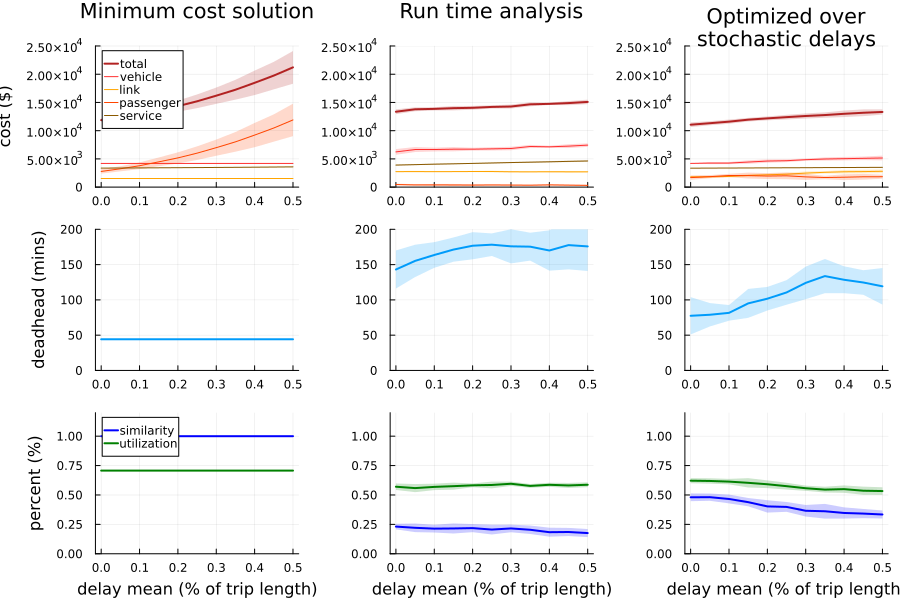

In [56]:
p1 = plot(
    multis,
    [mcf_dict["total_cost"] mcf_dict["vehicle_cost"] mcf_dict["link_cost"] mcf_dict["passenger_cost"] mcf_dict["service_cost"]],
    ribbon=[mcf_dict["total_cost_std"] mcf_dict["vehicle_cost_std"] mcf_dict["link_cost_std"] mcf_dict["passenger_cost_std"] mcf_dict["service_cost_std"]],
    label=["total" "vehicle" "link" "passenger" "service"],
    color=[:firebrick :firebrick1 :orange :orangered :orange4],
    lw=[2 1 1 1 1],
    fillalpha=0.2,
    ylims=(0, 25000),
    ylabel="cost (\$)",
    title="Minimum cost solution",
    legend=:topleft
)
p2 = plot(
    multis,
    mcf_dict["deadhead"],
    ribbon=mcf_dict["deadhead_std"],
    label="",
    lw=2,
    fillalpha=0.2,
    ylabel="deadhead (mins)",
    ylims = (0, 200),
    legend=:topleft
)
p3 = plot(
    multis,
    [mcf_dict["similarity"] mcf_dict["utilization"]],
    ribbon=[mcf_dict["similarity_std"] mcf_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay mean (% of trip length)",
    ylims=(0, 1.2),
    ylabel="percent (%)",
    legend=:topleft
)
p4 = plot(
    multis,
    [rta_dict["total_cost"] rta_dict["vehicle_cost"] rta_dict["link_cost"] rta_dict["passenger_cost"] rta_dict["service_cost"]],
    ribbon=[rta_dict["total_cost_std"] rta_dict["vehicle_cost_std"] rta_dict["link_cost_std"] rta_dict["passenger_cost_std"] rta_dict["service_cost_std"]],
    label=["total" "vehicle" "link" "passenger" "service"],
    color=[:firebrick :firebrick1 :orange :orangered :orange4],
    lw=[2 1 1 1 1],
    fillalpha=0.2,
    ylims=(0, 25000),
    title="Run time analysis",
    legend=nothing
)
p5 = plot(
    multis,
    rta_dict["deadhead"],
    ribbon=rta_dict["deadhead_std"],
    label="",
    lw=2,
    fillalpha=0.2,
    ylims = (0, 200),
    legend=nothing
)
p6 = plot(
    multis,
    [rta_dict["similarity"] rta_dict["utilization"]],
    ribbon=[rta_dict["similarity_std"] rta_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay mean (% of trip length)",
    ylims=(0, 1.2),
    legend=nothing
)
p7 = plot(
    multis,
    [stoch_dict["total_cost"] stoch_dict["vehicle_cost"] stoch_dict["link_cost"] stoch_dict["passenger_cost"] stoch_dict["service_cost"]],
    ribbon=[stoch_dict["total_cost_std"] stoch_dict["vehicle_cost_std"] stoch_dict["link_cost_std"] stoch_dict["passenger_cost_std"] stoch_dict["service_cost_std"]],
    label=["total" "vehicle" "link" "passenger" "service"],
    color=[:firebrick :firebrick1 :orange :orangered :orange4],
    lw=[2 1 1 1 1],
    fillalpha=0.2,
    ylims=(0, 25000),
    title="Optimized over\nstochastic delays",
    legend=nothing
)
p8 = plot(
    multis,
    stoch_dict["deadhead"],
    ribbon=stoch_dict["deadhead_std"],
    label="",
    lw=2,
    fillalpha=0.2,
    ylims = (0, 200),
    legend=nothing
)
p9 = plot(
    multis,
    [stoch_dict["similarity"] stoch_dict["utilization"]],
    ribbon=[stoch_dict["similarity_std"] stoch_dict["utilization_std"]],
    label=["similarity" "utilization"],
    color=[:blue :green],
    lw=2,
    fillalpha=0.2,
    xlabel="delay mean (% of trip length)",
    ylims=(0, 1.2),
    legend=nothing
)
rta_comparison_plot = plot(p1, p4, p7, p2, p5, p8, p3, p6, p9,  layout=(3, 3), link=:xy, size=(900, 600))
# savefig(rta_comparison_plot, ".\\imgs\\VSP-PD-am_short-10_10-rta_comparison_mean.png")

## Bender's decomposition

In [9]:
# fs = FirstStageProblem(instance; timeLimit = 10)
# add_benders_callback!(fs)
# bd_solution = solve!(fs);
# @show mean(lp_callback_runtimes)
# @show mean(get_p_callback_runtimes);
# MOI.get(fs.model, MOI.RelativeGap())
# plotVSP(bd_solution)

## 10 sec opt gap

In [11]:
# instance_sizes = 100:100:500
# opt_gap_IP = []
# opt_gap_BD = []

# for size in instance_sizes
#     sum_IP = 0
#     sum_BD = 0
#     for i in 1:5
#         subset = subsetGTFS(trips, size, randomSeed = i)
#         instance = VSPInstance(subset)
#         model_IP = VSPModel(instance, isInt = true, multiObj = false, timeLimit = 10)
#         model_BD = FirstStageProblem(instance, timeLimit = 10)
#         add_benders_callback!(model_BD)
#         sol_IP = solve!(model_IP);
#         sol_BD = solve!(model_BD);
#         sum_IP += MOI.get(model_IP.model, MOI.RelativeGap())
#         sum_BD += MOI.get(model_BD.model, MOI.RelativeGap())
#     end
#     push!(opt_gap_IP, sum_IP / 5)
#     push!(opt_gap_BD, sum_BD / 5)
# end
@show [opt_gap_IP opt_gap_BD]

[opt_gap_IP opt_gap_BD] = [6.031947682607448e-6 0.1629275916113045; 0.027256919099971622 0.47132052625010956; 0.526180825699331 0.768839649480148; 0.7067324202226736 0.8463141117589137]


4×2 Matrix{Float64}:
 6.03195e-6  0.162928
 0.0272569   0.471321
 0.526181    0.76884
 0.706732    0.846314

## Lagrange relaxation

In [51]:
LR = LagrangeRelaxation(instance)

for i ∈ 1:100
    status = update!(LR)
    if status
        println(i)
        break
    end
end

Solution found within 1% optimality gap.
3


In [60]:
# plot([LR.UB LR.LB])
# hline!([objectiveValue(vsp_solution.x, vsp_solution.s, instance.C, instance.M)])
# plot(LR.opt_gap, ylims = [0, 1])
# LR.λ
# println(
#     "vsp: ",
#     sum(LR.x[LR.best_idx[1]] .+ vsp_solution.x .> 1) / sum(vsp_solution.x),
#     "; mcf: ",
#     sum(LR.x[LR.best_idx[1]] .+ mcf_solution.x .> 1) / sum(mcf_solution.x)
# )
# (minimum(LR.UB) .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# (LR.UB[1] .- objective_value(vsp_model.model)) ./ objective_value(vsp_model.model)
# LR.s_adj
# plotVSP(instance, LR.x[LR.best_idx[1]], LR.s_adj[LR.best_idx[1]])

## solve times

In [8]:
# solve times
# instance_sizes = 20:20:200
# sol_times_LP = []
# sol_times_IP = []
# sol_times_BD = []

# for size in instance_sizes
#     sum_LP = 0
#     sum_IP = 0
    # sum_BD = 0
    # for i in 1:5
    #     subset = subsetGTFS(trips, size, randomSeed = i)
    #     instance = VSPInstance(subset)
    #     model_LP = VSPModel(instance, isInt = false, multiObj = false)
    #     model_IP = VSPModel(instance, isInt = true, multiObj = false)
        # model_BD = FirstStageProblem(instance)
        # add_benders_callback!(model_BD)
        # sol_LP = solve!(model_LP);
        # sol_IP = solve!(model_IP);
        # sol_BD = solve!(model_BD);
        # sum_LP += sol_LP.solve_time
        # sum_IP += sol_IP.solve_time
        # sum_BD += sol_BD.solve_time
    # end
    # push!(sol_times_LP, sum_LP / 5)
    # push!(sol_times_IP, sum_IP / 5)
    # push!(sol_times_BD, sum_BD / 5)
# end
# plot(
#     instance_sizes,
#     [sol_times_LP sol_times_IP];
#     xlabel = "number of trips",
#     ylabel = "solve time",
#     title = "LP, and IP solution times",
#     label = ["LP" "IP"]
# )
# png(".\\imgs\\VSP-PD-solve_times-BD")

## Pareto frontier

In [94]:
# Pareto frontier
# mod = del_model.model
# used_vehicles = [round(sum(value.(del_model.x[1, :]; result = i)); digits = 3) for i in 1:result_count(mod)]
# ideal_point = objective_bound(mod)
# pareto_plot = hline([ideal_point[2]]; color = :red, lw = 2, label = "", ylims = [1000, 2000], xlims = [-0.2, 7])
# vline!([ideal_point[1]]; color = :red, lw = 2, label = "objective bounds")
# Plots.scatter!(
#     [objective_value(mod; result = i)[1] for i in 1:result_count(mod)],
#     [objective_value(mod; result = i)[2] for i in 1:result_count(mod)];
#     xlabel = "delay",
#     ylabel = "cost",
#     title = "# trips: $(instance.n-1)",
#     label = "fleet used",
# )
# for i in 1:result_count(mod)
#     y = objective_value(mod; result = i)
#     Plots.annotate!(y[1], y[2] + 10, (used_vehicles[i], 10))
# end
# png(".\\imgs\\VSP-PD-$(instance.n-1)-pareto")
# pareto_plot